/tmp/ipykernel_116670/2804176958.py:99: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'CreationDate', 'Author', 'Title', 'Creator', 'Keywords', 'Trapped', 'Producer', 'Subject'}.
  plt.savefig(f'figs/casscf_{fig_titles[i].lower().replace(" ", "_")}_combined.pdf',
/tmp/ipykernel_116670/2804176958.py:120: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'CreationDate', 'Author', 'Title', 'Creator', 'Keywords', 'Trapped', 'Producer', 'Subject'}.
  plt.savefig('figs/casscf_energy_difference_combined.pdf', metadata={"TextAsShapes": False})


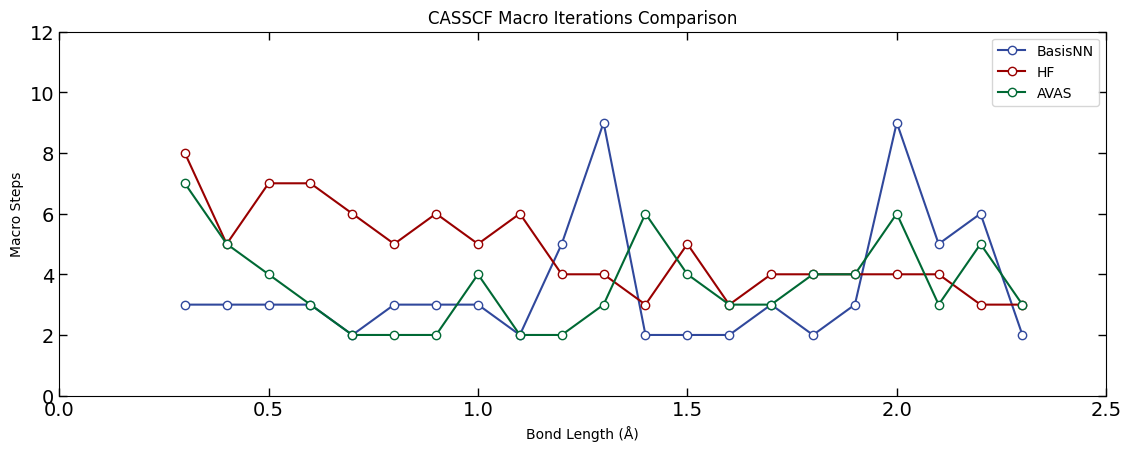

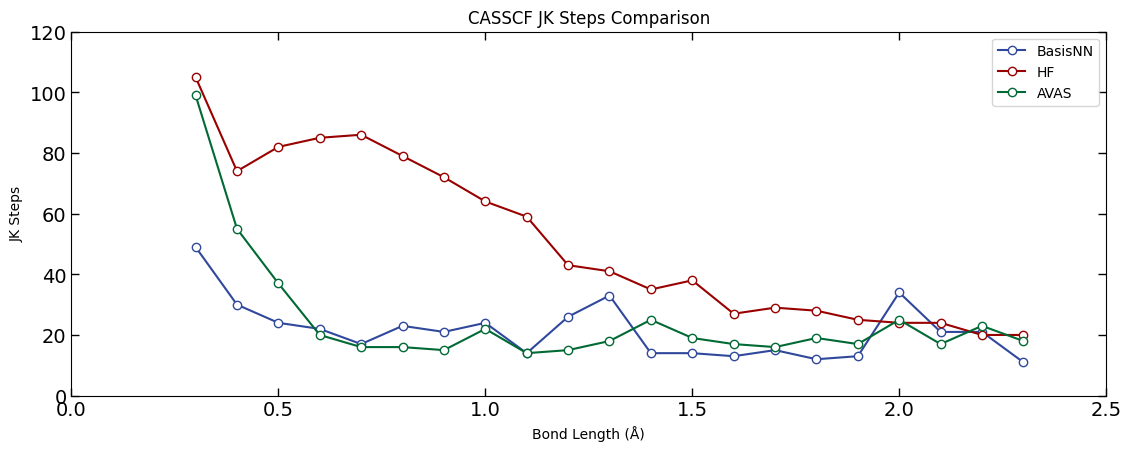

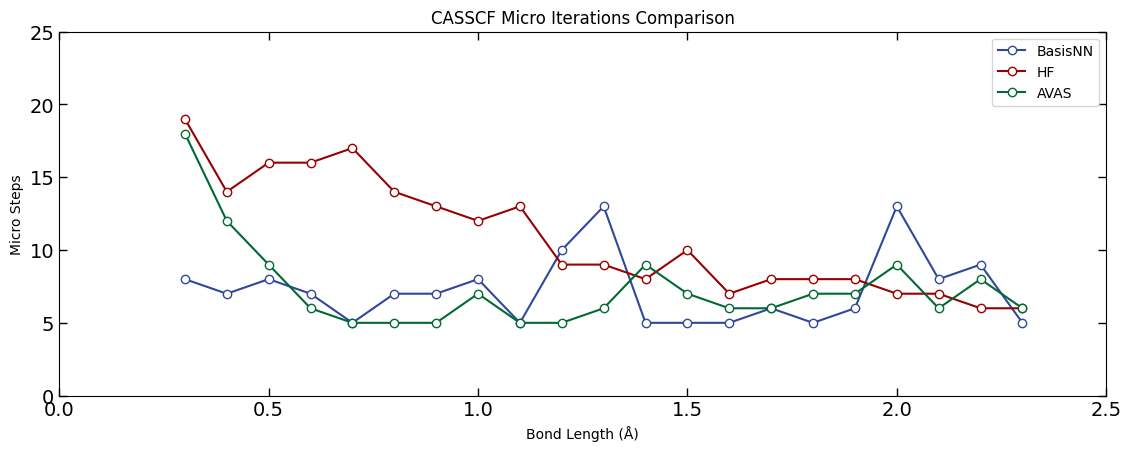

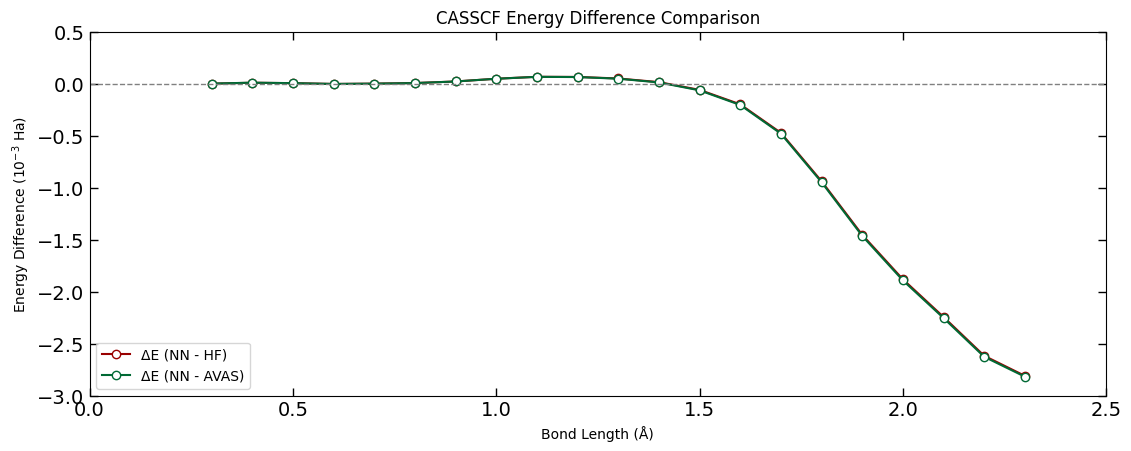

In [15]:
import numpy as np
import re
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# ---------- CONFIG ----------
num_chains = 25  # Number of chains
bond_length_interval = 0.1
lengths = [bond_length_interval * point for point in range(3, num_chains + 1)]

# Regex patterns
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')

def extract_data(folder):
    """Extract NN and method (HF or AVAS) data from logs."""
    log_files = sorted(glob.glob(f"{folder}/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))
    nn_macro, nn_jk, nn_micro = [], [], []
    method_macro, method_jk, method_micro = [], [], []
    nn_energy, method_energy = [], []
    indices = []

    for log_file in log_files:
        with open(log_file, "r") as f:
            lines = f.readlines()

        matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
        matches_steps = [m for m in matches_steps if m]
        matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
        matches_energy = [m for m in matches_energy if m]

        if len(matches_steps) >= 2 and len(matches_energy) >= 2:
            nn_data = tuple(map(int, matches_steps[0].groups()))
            method_data = tuple(map(int, matches_steps[1].groups()))
            nn_macro.append(nn_data[0])
            nn_jk.append(nn_data[1])
            nn_micro.append(nn_data[2])
            method_macro.append(method_data[0])
            method_jk.append(method_data[1])
            method_micro.append(method_data[2])
            nn_energy.append(float(matches_energy[0].group(1)))
            method_energy.append(float(matches_energy[1].group(1)))
            indices.append(int(re.search(r'\d+', log_file).group()))

    return {
        "indices": indices,
        "nn_macro": nn_macro, "nn_jk": nn_jk, "nn_micro": nn_micro,
        "nn_energy": nn_energy,
        "method_macro": method_macro, "method_jk": method_jk, "method_micro": method_micro,
        "method_energy": method_energy
    }


# ---------- READ BOTH SETS ----------
hf_data = extract_data("cas_init_result")
avas_data = extract_data("cas_init_result_avas")

# ---------- PLOTTING ----------
fig_titles = ['Macro Iterations', 'JK Steps', 'Micro Iterations']
ylabels = ['Macro Steps', 'JK Steps', 'Micro Steps']
y2_l = [12, 120, 25]  # y-axis limits

# Convert mm to inches
width_in = 58 / 25.4 * 5
height_in = 23.455 / 25.4 * 5

# ---------- LOOP OVER STEP TYPES ----------
for i, (label, ylim) in enumerate(zip(ylabels, y2_l)):
    plt.figure(figsize=(width_in, height_in))

    # NN (same for both HF and AVAS sets)
    plt.plot(lengths[:-2], hf_data["nn_macro"][:-2] if i == 0 else
             hf_data["nn_jk"][:-2] if i == 1 else hf_data["nn_micro"][:-2],
             label='BasisNN', marker='o', markerfacecolor='white',
             color=(48/255, 72/255, 156/255))

    # HF
    plt.plot(lengths[:-2], hf_data["method_macro"][:-2] if i == 0 else
             hf_data["method_jk"][:-2] if i == 1 else hf_data["method_micro"][:-2],
             label='HF', marker='o', markerfacecolor='white',
             color=(153/255, 0/255, 0/255))

    # AVAS
    plt.plot(lengths[:-2], avas_data["method_macro"][:-2] if i == 0 else
             avas_data["method_jk"][:-2] if i == 1 else avas_data["method_micro"][:-2],
             label='AVAS', marker='o', markerfacecolor='white',
             color=(0/255, 105/255, 52/255))

    plt.xlabel('Bond Length (Å)')
    plt.ylabel(label)
    plt.title(f'CASSCF {fig_titles[i]} Comparison')
    plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
    plt.xlim(0, 2.5)
    plt.ylim(0, ylim)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figs/casscf_{fig_titles[i].lower().replace(" ", "_")}_combined.pdf',
                metadata={"TextAsShapes": False})

# ---------- ENERGY DIFFERENCE PLOTS ----------
energy_diff_hf = np.array([nn - hf for nn, hf in zip(hf_data["nn_energy"], hf_data["method_energy"])]) * 1e3
energy_diff_avas = np.array([nn - avas for nn, avas in zip(avas_data["nn_energy"], avas_data["method_energy"])]) * 1e3

plt.figure(figsize=(width_in, height_in))
plt.plot(lengths[:-2], energy_diff_hf[:-2], label='ΔE (NN - HF)',
         marker='o', markerfacecolor='white', color= (153/255, 0/255, 0/255))
plt.plot(lengths[:-2], energy_diff_avas[:-2], label='ΔE (NN - AVAS)',
         marker='o', markerfacecolor='white', color= (0/255,105/255,52/255))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy Difference ($10^{-3}$ Ha)')
plt.title('CASSCF Energy Difference Comparison')
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.xlim(0, 2.5)
plt.ylim(-3, 0.5)
plt.legend()
plt.tight_layout()
plt.savefig('figs/casscf_energy_difference_combined.pdf', metadata={"TextAsShapes": False})

plt.show()


Parsed lengths: {'NN': 3, 'HF': 7, 'AVAS': 3}


/tmp/ipykernel_116670/2315182963.py:126: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'CreationDate', 'Author', 'Title', 'Creator', 'Keywords', 'Trapped', 'Producer', 'Subject'}.
  plt.savefig('figs/casscf_convergence_all.pdf', metadata={"TextAsShapes": False})


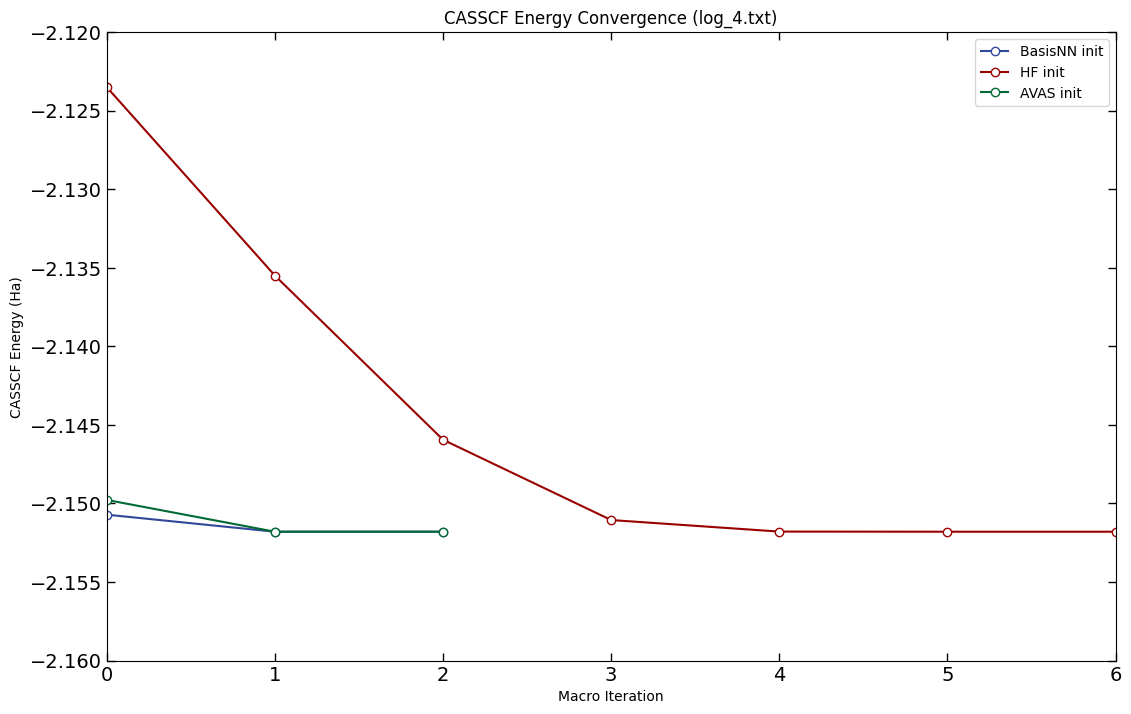

In [13]:
import re
import matplotlib.pyplot as plt

# --- File paths ---
hf_log = "cas_init_result/log_4.txt"       # HF vs NN
avas_log = "cas_init_result_avas/log_4.txt"  # AVAS vs NN

# --- Regex patterns ---
mark = re.compile(r"Running CASSCF with\s+(NN|HF|AVAS)[^\n]*?initial guess", re.I)
NUM = r"[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?"
re_casci = re.compile(rf"CASCI\s+(?:energy|E)\s*=\s*({NUM})", re.I)
re_casscf_e = re.compile(rf"(?:Final\s+)?CASSCF\s+(?:E|energy)\s*=\s*({NUM})", re.I)
re_macro_idx = re.compile(r"macro\s*iter\s*(\d+)", re.I)
re_macro_pair = re.compile(rf"macro\s*iter\s*(\d+).*?CASSCF\s+(?:E|energy)\s*=\s*({NUM})", re.I)
re_converged = re.compile(r"CASSCF\s+converged\s+in\s+(\d+)\s+macro", re.I)

def extract_blocks(text):
    """Split log file into labeled chunks (NN, HF, AVAS)."""
    starts = list(mark.finditer(text))
    blocks = []
    for i, m in enumerate(starts):
        a = m.end()
        b = starts[i + 1].start() if i + 1 < len(starts) else len(text)
        blocks.append((m.group(1).upper(), text[a:b]))
    return blocks

def series_from_block(txt, join_window=8, densify=True):
    """Extract energy vs macro iteration."""
    mconv = re_converged.search(txt)
    if mconv:
        max_macro = int(mconv.group(1))
        txt_core = txt[:mconv.start()]
    else:
        max_macro = None
        txt_core = txt

    m0 = re_casci.search(txt_core) or re_casci.search(txt)
    if m0:
        E0 = float(m0.group(1))
    else:
        mf = re_casscf_e.search(txt_core) or re_casscf_e.search(txt)
        if not mf:
            return [], []
        E0 = float(mf.group(1))

    macro_to_E = {}
    for k, e in re_macro_pair.findall(txt_core):
        macro_to_E[int(k)] = float(e)

    if not macro_to_E:
        lines = txt_core.splitlines()
        n = len(lines)
        for i, line in enumerate(lines):
            mi = re_macro_idx.search(line)
            if not mi:
                continue
            k = int(mi.group(1))
            E = None
            for j in range(i, min(i + join_window, n)):
                me = re_casscf_e.search(lines[j])
                if me:
                    E = float(me.group(1))
                    break
            if E is not None:
                macro_to_E[k] = E

    if max_macro is not None:
        macro_to_E = {k: v for k, v in macro_to_E.items() if k <= max_macro}

    if not macro_to_E:
        return [0], [E0]

    ks = sorted(macro_to_E)
    xs = [0] + ks
    ys = [E0] + [macro_to_E[k] for k in ks]

    if densify and max_macro is not None:
        full_x = list(range(0, max_macro + 1))
        y_map = dict(zip(xs, ys))
        full_y, last = [], None
        for k in full_x:
            last = y_map.get(k, last if last is not None else E0)
            full_y.append(last)
        return full_x, full_y

    return xs, ys

# --- Parse both logs ---
series_all = {}

for label, filepath in [("HF-NN", hf_log), ("AVAS-NN", avas_log)]:
    with open(filepath, "r") as f:
        text = f.read()
    for method, chunk in extract_blocks(text):
        key = f"{method}_{label}"
        series_all[key] = series_from_block(chunk)

# Extract NN from both (should be similar but we can just take one)
x_nn, y_nn = series_all.get("NN_HF-NN", ([], []))
x_hf, y_hf = series_all.get("HF_HF-NN", ([], []))
x_avas, y_avas = series_all.get("AVAS_AVAS-NN", ([], []))

print("Parsed lengths:", {"NN": len(y_nn), "HF": len(y_hf), "AVAS": len(y_avas)})

if not y_nn or not y_hf or not y_avas:
    raise RuntimeError("Missing one or more energy traces. Check log file contents.")

# --- Plot all three ---
width_in = 58 / 25.4 * 5
height_in = 36.8 / 25.4 * 5

plt.figure(figsize=(width_in, height_in))
plt.plot(x_nn, y_nn, label="BasisNN init", marker='o', markerfacecolor='white', color=(48/255, 72/255, 156/255))
plt.plot(x_hf, y_hf, label="HF init", marker='o', markerfacecolor='white', color=(153/255, 0/255, 0/255))
plt.plot(x_avas, y_avas, label="AVAS init", marker='o', markerfacecolor='white', color=(0/255, 105/255, 52/255))

plt.xlabel("Macro Iteration")
plt.ylabel("CASSCF Energy (Ha)")
plt.title("CASSCF Energy Convergence (log_4.txt)")
plt.xlim(0, 6)
plt.ylim(-2.16, -2.12)
plt.legend()
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.tight_layout()

plt.savefig('figs/casscf_convergence_all.pdf', metadata={"TextAsShapes": False})
plt.show()
